<a href="https://colab.research.google.com/github/sofiiimr/46120-PiWE/blob/main/docs/notebooks/cables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cables

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/cables.ipynb) (requires google account)


TOPFARM can use the Electrical Network Design package EDWIN to optimize the carray cabels as well as the substation position at each iteration of the layout optimization

**Install TOPFARM if needed**

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git to /tmp/pip-req-build-7x00ed3d
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git /tmp/pip-req-build-7x00ed3d
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git to commit fb5b0bb26f307630e7f06b000de4f1b0682e5305
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 87.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Install EDWIN if needed
import importlib
if not importlib.util.find_spec("ed_win"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git#egg=ed_win[interarray]

DEPRECATION: git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git#egg=ed_win[interarray] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git to /tmp/pip-install-3j6p57i0/ed-win_30ed33c4a42b4bc5b760f20d8b8c6e5c
  Running command git clone --filter=blob:none --quiet https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git /tmp/pip-install-3j6p57i0/ed-win_30ed33c4a42b4bc5b760f20d8b8c6e5c
  Resolved https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git to commit 517099b186a093556129aa75c968924861f9b9b1
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 53.9 MB/s e

### Import

In [3]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.utils import plot_list_recorder
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines
from py_wake import BastankhahGaussian
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
# from py_wake.examples.data.nysted import nysted

from ed_win.wind_farm_network import WindFarmNetwork

Diameter 80.0
Hub height 70.0


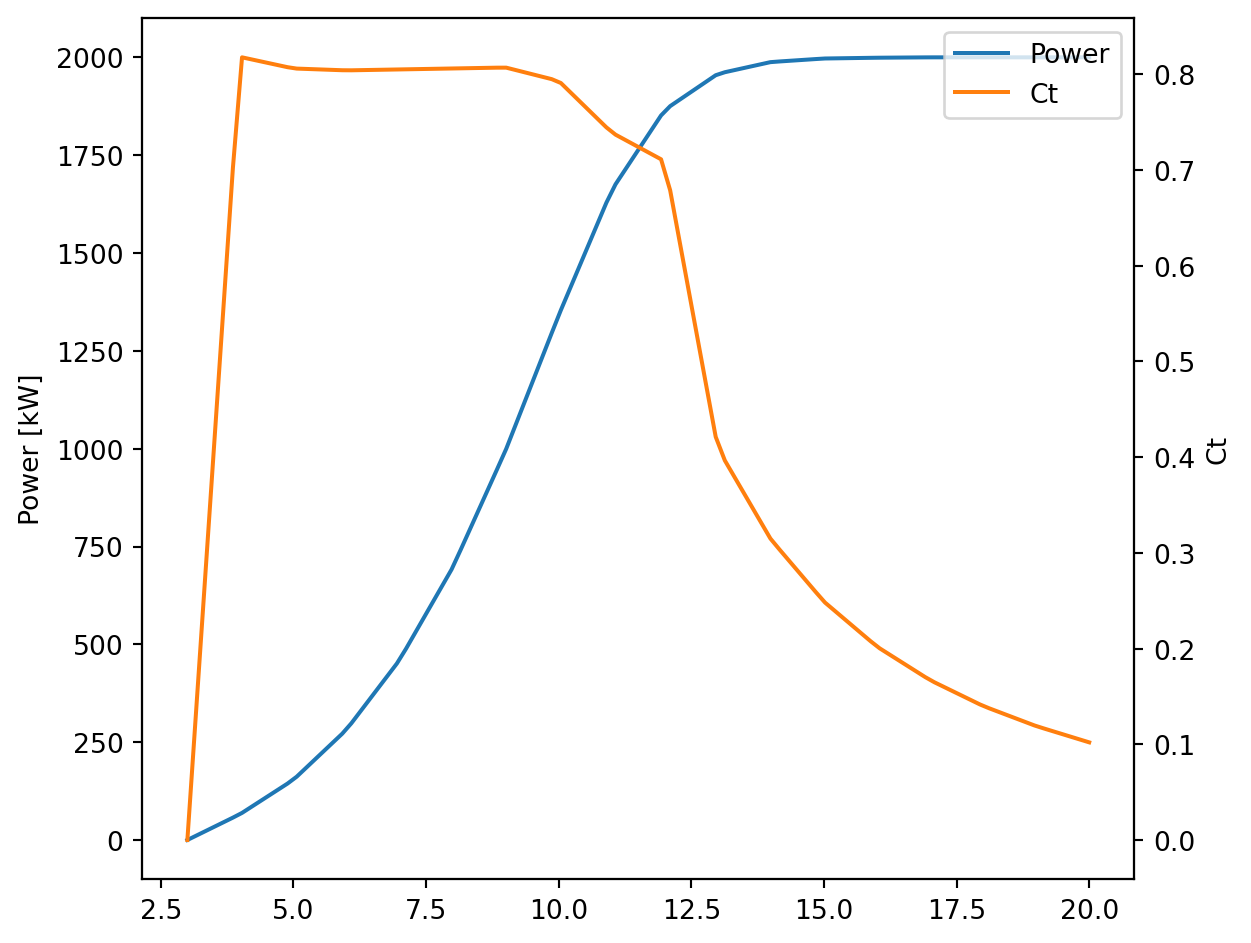

In [7]:
from py_wake import np
from py_wake.site._site import UniformWeibullSite
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

wt_x = [0.0, -1.23, -2.45, -3.68, -4.9, -6.13, -7.35, -8.58, -9.8,
        852.36, 851.6, 850.83, 850.07, 849.3, 848.54, 847.77, 847.01, 846.24,
        1704.72, 1704.42, 1704.11, 1703.81, 1703.5, 1703.2, 1702.89, 1702.59, 1702.28,
        2557.08, 2557.24, 2557.4, 2557.57, 2557.73, 2557.89, 2558.06, 2558.22, 2558.38,
        3409.44, 3410.07, 3410.7, 3411.33, 3411.96, 3412.59, 3413.22, 3413.85, 3414.48,
        4261.8, 4262.91, 4264.02, 4265.13, 4266.24, 4267.35, 4268.46, 4269.57, 4270.68,
        5114.16, 5115.74, 5117.33, 5118.91, 5120.5, 5122.08, 5123.67, 5125.25, 5126.84,
        5966.52, 5968.57, 5970.62, 5972.67, 5974.72, 5976.77, 5978.82, 5980.87, 5982.92]

wt_y = [0.0, 482.04, 964.08, 1446.11, 1928.15, 2410.19, 2892.23, 3374.27, 3856.3,
        -132.58, 336.89, 806.36, 1275.82, 1745.29, 2214.76, 2684.23, 3153.7, 3623.17,
        -265.15, 191.75, 648.65, 1105.55, 1562.45, 2019.35, 2476.25, 2933.15, 3390.05,
        -397.73, 46.61, 490.94, 935.28, 1379.61, 1823.95, 2268.29, 2712.62, 3156.96,
        -530.31, -98.54, 333.23, 765.01, 1196.78, 1628.55, 2060.32, 2492.09, 2923.86,
        -662.89, -243.7, 175.49, 594.67, 1013.86, 1433.05, 1852.23, 2271.42, 2690.61,
        -795.47, -388.86, 17.74, 424.34, 830.94, 1237.55, 1644.15, 2050.75, 2457.35,
        -928.05, -534.01, -139.01, 255.99, 650.99, 1045.99, 1440.99, 1835.99, 2230.99,
        -1060.63, -679.17, -297.76, 83.65, 465.06, 846.47, 1227.88, 1609.29, 1990.7]

wt9_x = np.array(wt_x)[[0, 1, 2, 8, 9, 10, 16, 17, 18]]
wt9_y = np.array(wt_y)[[0, 1, 2, 8, 9, 10, 16, 17, 18]]
i16 = [0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27]
wt16_x = np.array(wt_x)[i16]
wt16_y = np.array(wt_y)[i16]


power_curve = np.array([[3.0, 0.0],
                        [4.0, 66.6],
                        [5.0, 154.0],
                        [6.0, 282.0],
                        [7.0, 460.0],
                        [8.0, 696.0],
                        [9.0, 996.0],
                        [10.0, 1341.0],
                        [11.0, 1661.0],
                        [12.0, 1866.0],
                        [13.0, 1958.0],
                        [14.0, 1988.0],
                        [15.0, 1997.0],
                        [16.0, 1999.0],
                        [17.0, 2000.0],
                        [18.0, 2000.0],
                        [19.0, 2000.0],
                        [20.0, 2000.0],
                        [21.0, 2000.0],
                        [22.0, 2000.0],
                        [23.0, 2000.0],
                        [24.0, 2000.0],
                        [25.0, 2000.0]]) * [1, 1000]
ct_curve = np.array([[3.0, 0.0],
                     [4.0, 0.818],
                     [5.0, 0.806],
                     [6.0, 0.804],
                     [7.0, 0.805],
                     [8.0, 0.806],
                     [9.0, 0.807],
                     [10.0, 0.793],
                     [11.0, 0.739],
                     [12.0, 0.709],
                     [13.0, 0.409],
                     [14.0, 0.314],
                     [15.0, 0.249],
                     [16.0, 0.202],
                     [17.0, 0.167],
                     [18.0, 0.14],
                     [19.0, 0.119],
                     [20.0, 0.102],
                     [21.0, 0.088],
                     [22.0, 0.077],
                     [23.0, 0.067],
                     [24.0, 0.06],
                     [25.0, 0.053]])


class V80(WindTurbine):
    def __init__(self, method='linear'):
        """
        Parameters
        ----------
        method : {'linear', 'pchip'}
            linear(fast) or pchip(smooth and gradient friendly) interpolation
        """
        WindTurbine.__init__(self, name='V80', diameter=80, hub_height=70,
                             powerCtFunction=PowerCtTabular(power_curve[:, 0], power_curve[:, 1], 'w',
                                                            ct_curve[:, 1], method=method))


HornsrevV80 = V80


class nysted(UniformWeibullSite):
    def __init__(self, ti=.1, shear=None):
        f = [3.597152, 3.948682, 5.167395, 7.000154, 8.364547, 6.43485,
             8.643194, 11.77051, 15.15757, 14.73792, 10.01205, 5.165975]
        a = [9.176929, 9.782334, 9.531809, 9.909545, 10.04269, 9.593921,
             9.584007, 10.51499, 11.39895, 11.68746, 11.63732, 10.08803]
        k = [2.392578, 2.447266, 2.412109, 2.591797, 2.755859, 2.595703,
             2.583984, 2.548828, 2.470703, 2.607422, 2.626953, 2.326172]
        UniformWeibullSite.__init__(self, np.array(f) / np.sum(f), a, k, ti=ti, shear=shear)
        self.initial_position = np.array([wt_x, wt_y]).T


def main():
    wt = V80()
    print('Diameter', wt.diameter())
    print('Hub height', wt.hub_height())

    import matplotlib.pyplot as plt
    ws = np.linspace(3, 20, 100)
    plt.plot(ws, wt.power(ws) * 1e-3, label='Power')
    c = plt.plot([], [], label='Ct')[0].get_color()
    plt.ylabel('Power [kW]')
    ax = plt.gca().twinx()
    ax.plot(ws, wt.ct(ws), color=c)
    ax.set_ylabel('Ct')
    plt.xlabel('Wind speed [m/s]')
    plt.gcf().axes[0].legend(loc=1)
    plt.show()


if __name__ == '__main__':
    main()


### Site

In [8]:
n_wt = 72
initial = np.asarray([np.random.random(30)*6000, np.random.random(30)*-10000]).T
x_init = initial[:,0]
y_init = initial[:,1]
boundary = np.array([(0, 0), (-9.8, 3856.3), (5956.7, 2798.0), (5966.5, -1060.6)])  # turbine boundaries
drivers = [EasyScipyOptimizeDriver(maxiter=10)]
windTurbines = IEA37_WindTurbines()
site = nysted()
wfm = BastankhahGaussian(site, windTurbines)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Bathymetry

In [ ]:
sigma = 3000.0
mu = 0.0

x_peak_1 = 1000
y_peak_1 = -1000
x_peak_2 = 4000
y_peak_2 = -8000
x1, y1 = np.meshgrid(np.linspace(0 - x_peak_1, 6000- x_peak_1, 100), np.linspace(-10000 - y_peak_1, 0 - y_peak_1, 100))
d1 = np.sqrt(x1*x1 + y1*y1)
g1 = np.exp(-((d1 - mu)**2 / (2.0 * sigma**2)))
x2, y2 = np.meshgrid(np.linspace(0 - x_peak_2, 6000- x_peak_2, 100), np.linspace(-10000 - y_peak_2, 0 - y_peak_2, 100))
d2 = np.sqrt(x2*x2 + y2*y2)
g2 = np.exp(-((d2 - mu)**2 / (2.0 * sigma**2)))
g = 5 * g1 - 8 * g2 - 30

plt.imshow(g, extent=(-1000, 7000, -11000, 1000), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian Function')
plt.show()

x = np.linspace(-1000, 7000, 100)
y = np.linspace(-11000, 1000, 100)

f = RegularGridInterpolator((x, y), g)

### Cables

In [ ]:
x_ss_init = x_init.mean()
y_ss_init = y_init.mean()
turbines_pos=np.asarray([x_init, y_init]).T
substations_pos = np.asarray([[x_ss_init], [y_ss_init]]).T

cables = np.array([[500, 3, 100], [800, 5, 150], [1000, 10, 250]])  # Here you set up cables [<cable cross section>, <number of turbines can be connected>, <price in € per meter>]

wfn = WindFarmNetwork(turbines_pos=turbines_pos, substations_pos=substations_pos, cables=cables)
G = wfn.optimize(turbines_pos)
cable_cost_ref = G.size(weight="cost")  # euro
cable_length_ref = G.size(weight="length")  # m
cost_per_length_ref = cable_cost_ref / cable_length_ref # euro / m

G.plot()

### Economy

In [ ]:
Drotor_vector = [windTurbines.diameter()] * n_wt
power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt
hub_height_vector = [windTurbines.hub_height()] * n_wt

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.1               # [Euro/kWh] What we get per kWh
project_duration = 25            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
simres = wfm(x_init, y_init)
aep = simres.aep().values.sum()
CF = aep / (windTurbines.power(20)*1e-9 * 24*365*n_wt)

eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)
npv_ref = eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, 30, aep/n_wt * np.ones(n_wt)*10**6, cabling_cost=cable_cost_ref)

### Python Functions

In [ ]:
# Water Depth
def water_depth_func(x, y, **kwargs):
    xnew, ynew = np.meshgrid(x, y)
    points = np.array([xnew.flatten(), ynew.flatten()]).T
    return - np.diag(f(points).reshape(n_wt, n_wt).T)

# Cables
def cable_func(x, y, x_substation, y_substation, **kwargs):
    G = wfn.optimize(turbines_pos= np.asarray([x, y]).T, substations_pos=np.asarray([[float(x_substation[0])], [float(y_substation[0])]]).T)
    return G.size(weight="cost"), {'cabling_length': G.size(weight="length")}

# Economy
def npv_func(AEP, water_depth, cabling_cost, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    CAPEX = eco_eval.project_costs_sums["CAPEX"]
    OPEX = eco_eval.project_costs_sums["OPEX"]
    return eco_eval.NPV, {'irr': eco_eval.IRR,
                          'OPEX': OPEX,
                          'CAPEX': CAPEX,}


### Components

In [ ]:
# Water Depth
water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=water_depth_func,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

# Cables
cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init), ('x_substation', x_ss_init), ('y_substation', y_ss_init)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cabling_cost', 0)],
                                     additional_output=[('cabling_length', 0)])

# Economy
npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt)), ('cabling_cost', 100000)],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0)],
                              additional_output=[('irr', 0),
                                                 ('CAPEX', 0),
                                                 ('OPEX', 0)])

# AEP
aep_comp = PyWakeAEPCostModelComponent(wfm, n_wt, objective=False)

### Problem Assembly

In [ ]:
cost_comp = TopFarmGroup([PyWakeAEPCostModelComponent(wfm, n_wt, objective=False), water_depth_component, cable_component, npv_comp])


tf = TopFarmProblem(
    design_vars=dict(zip('xy', initial.T), x_substation=x_ss_init, y_substation=y_ss_init),
    cost_comp=cost_comp,
    constraints=[XYBoundaryConstraint(boundary),
                 SpacingConstraint(500)
                 ],
    driver=drivers[0],
    plot_comp=XYPlotComp()
)


### Optimize

In [ ]:
cost, _, recorder = tf.optimize()


### Plot

In [ ]:
plot_list_recorder(recorder)

In [ ]:
x_opt = recorder['x'][-1]
y_opt = recorder['y'][-1]
x_sub_opt = recorder['x_substation'][-1]
y_sub_opt = recorder['y_substation'][-1]
G = wfn.optimize(np.asarray([x_opt, y_opt]).T,
                 substations_pos=np.asarray([[float(x_sub_opt)], [float(y_sub_opt)]]).T,
                 )
G.plot()
